In [1]:
import h5py
import numpy as np
import Functions.Binning as Bin
import copy
import importlib
import matplotlib.pyplot as plt
import Functions.AllFunctions as AllF
import Functions.Make_pandaBinsDataset as MPB
import pandas as pd
from scipy.signal import correlate
from scipy.optimize import curve_fit
import math
import Functions.Autocorr as Aut
import Functions.UnifyWormsFun as UNF
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from numpy.polynomial.polynomial import Polynomial

/mnt/DATA/Mahsa/movies/LongRecordings/codes/Cluster


In [2]:
h5 = h5py.File('MegaData7_7worms_V4.h5', 'r')#h5 = h5py.File('MegaData7_7worms_V2_update.h5', 'r')#h5 = h5py.File('MegaData7_copy4.h5', 'r')

In [3]:
L= h5['data_sets_info/lowercam_length']
n_title = [s.decode('utf-8') for s in list(h5['data_sets_info/neuron_names'])]
MegaData0 = np.copy(h5['data/dataraw'])
MegaData0[np.isnan(MegaData0)]=0
MegaData =copy.deepcopy(MegaData0)

In [5]:
smooth=True
gapfilled = True
numW=7

In [6]:
for i in range(55):
    if i >12 and not (i in [27,28,39,40]):
        MegaData[5,:243,i] = 0
        MegaData0[5,:243,i] = 0

for i in range(55):
    MegaData[6,L[6]:,i] = 0
    MegaData0[6,L[6]:,i] = 0

In [7]:
# try different smoothing and interpolating on the data

sm = [2,2,2,3,4,3,3]
g=[5,5,5,7,10,7,7]
if smooth:
    for d in range(7):
        for i in range(55):
            if not (i in [10,11,12]):
                MegaData[d,:L[d],i] = Bin.smooth_vec_long(MegaData0[d,:L[d],i],sm[d],g[d])


MegaData_filled =copy.deepcopy(MegaData0)
importlib.reload(AllF)
if gapfilled:
    for d in range(7):
        for i in range(55):
            if not (i in [10,11,12]):
                MegaData_filled[d,:L[d],i] = AllF.fill_in_gaps(MegaData0[d,:L[d],i],g[d])


MegaData_fs =copy.deepcopy(MegaData0)
if smooth and gapfilled:
    for d in range(7):
        for i in range(55):
            if not (i in [10,11,12]):
                MegaData_fs[d,:L[d],i] = Bin.smooth_vec_long(MegaData_filled[d,:L[d],i],sm[d],g[d])

MegaData_filled[MegaData_filled==0] = np.nan

MegaData_interp = copy.deepcopy(MegaData_filled)
for d in range(numW):
    for n in range(55):
        if not (n in [10,11,12]):
            time = MegaData0[d,:L[d],12]
            values = MegaData_filled[d,:L[d],n]
            df = pd.DataFrame({'time': time, 'values': values})
            window_size = 3
            df['values2'] = df['values'].interpolate(method='linear')
            smoothed_values1 = savgol_filter(df['values2'], window_length=5, polyorder=1)
            df['smoothed_values1'] = smoothed_values1
            MegaData_interp[d,:L[d],n] = smoothed_values1

MegaData_interp[np.isnan(MegaData_interp)]=0
MegaData_filled[np.isnan(MegaData_filled)]=0

In [13]:
WormLabel = ['W0','W1','W2','W3','W4','W5','W6']
Neur_lab = ["RIAL","RIAR","RIML","RIMR","RIBL","RIBR",'Sens.',"nrDL","loopL","nrDR","loopR","nrVL","nrVR"]

In [14]:
%matplotlib widget

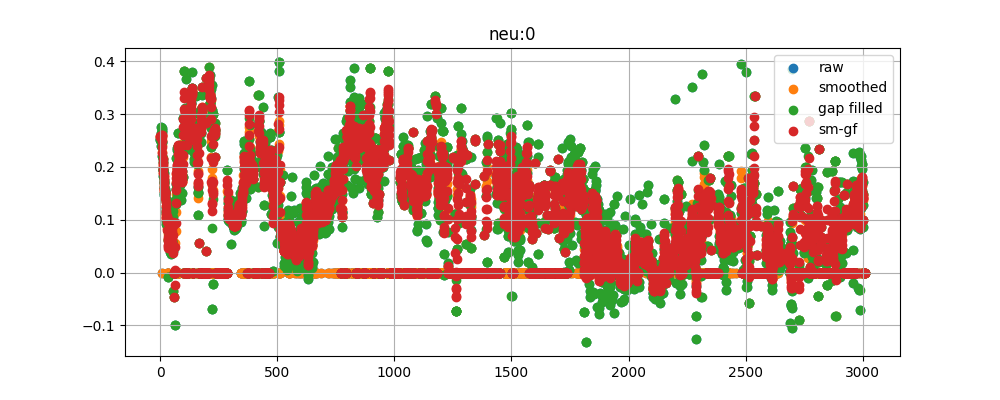

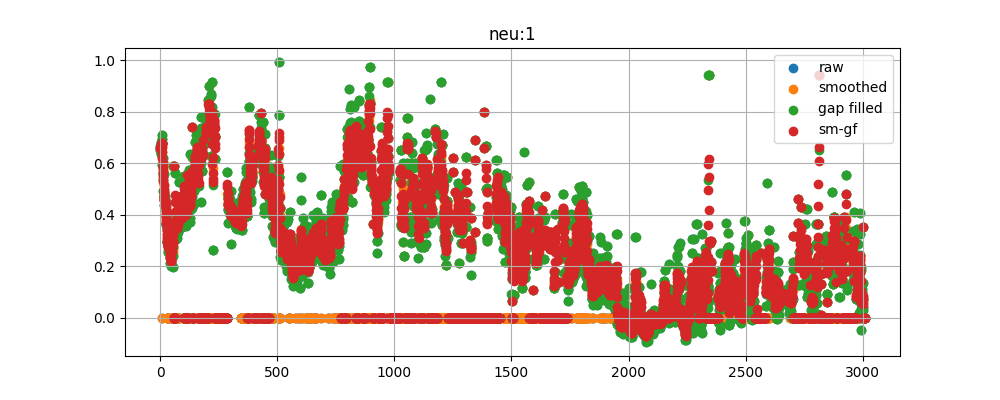

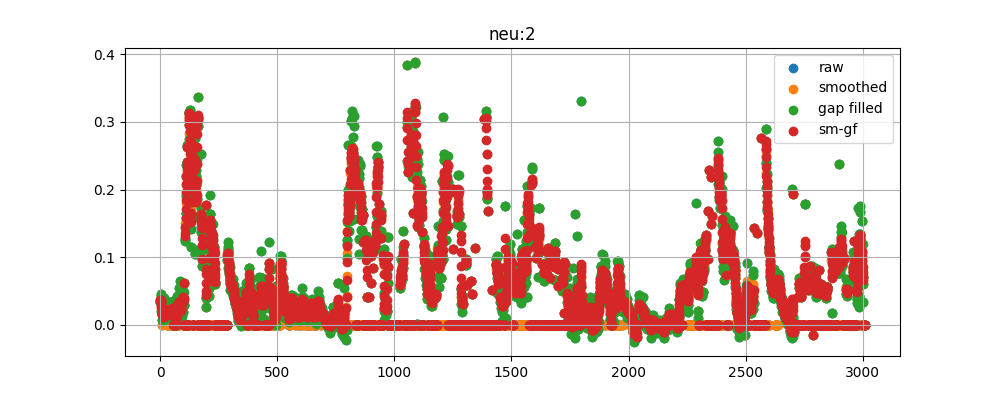

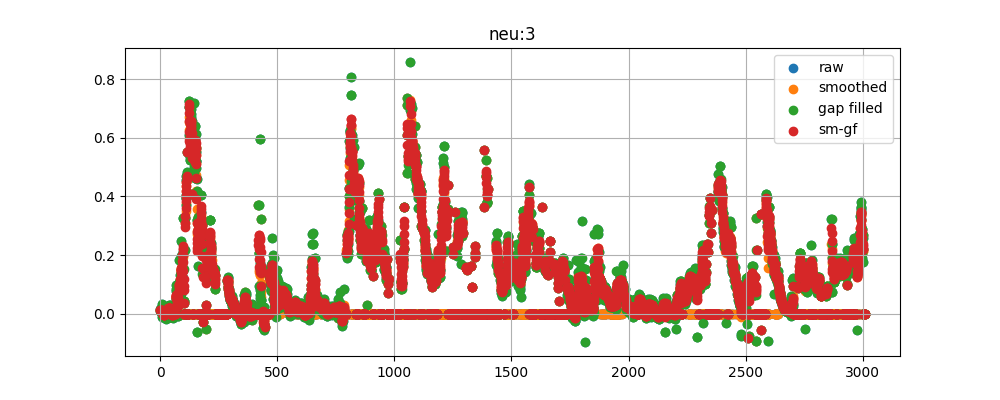

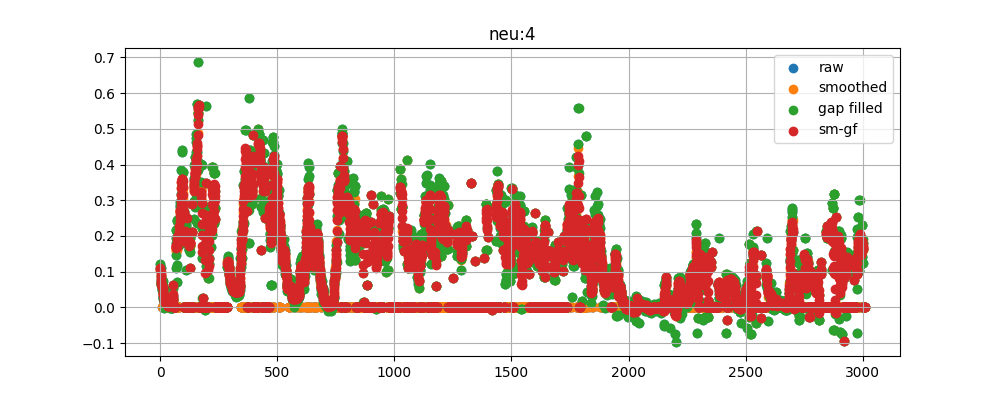

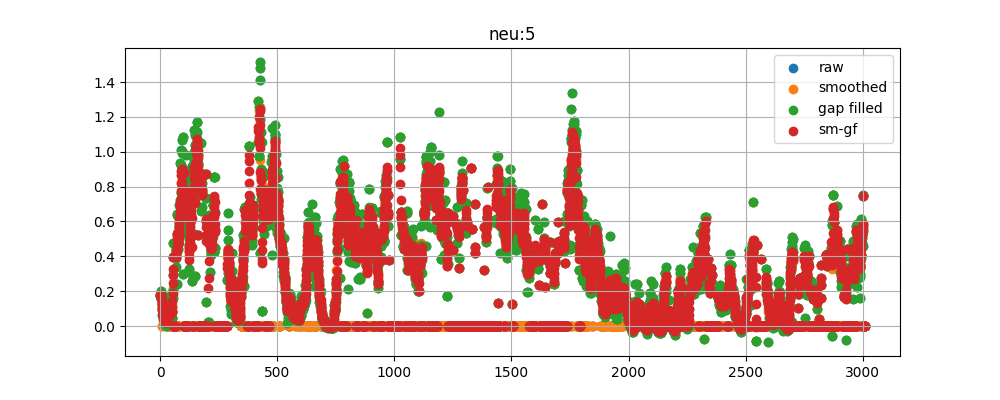

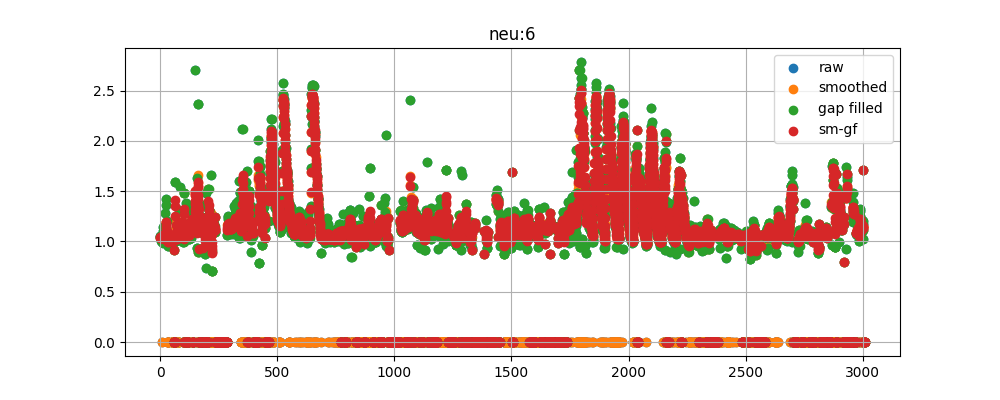

In [15]:
# for worm d plot neurons RIA,RIM,RIB, and  sensory  plot raw, smoothed, gap filled, and somoothed & gapfilled on top of each other
# xaxis is time stamps in seconds
d=1
a= 1
for n in range(7):
    endt = L[d]
    xaxis = MegaData0[d,:endt,12]
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot()
    ax.scatter(xaxis,MegaData0[d,:endt,n],label='raw',alpha=a)
    ax.scatter(xaxis,MegaData[d,:endt,n],label='smoothed',alpha=a)
    ax.scatter(xaxis,MegaData_filled[d,:endt,n],label='gap filled',alpha=a)
    ax.scatter(xaxis,MegaData_fs[d,:endt,n],label='sm-gf',alpha=a)
    ax.set_title('neu:'+str(n))
    plt.legend()
    plt.grid()
    plt.show()

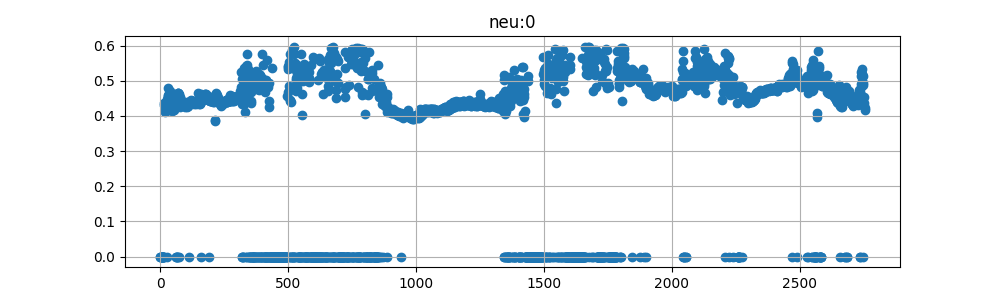

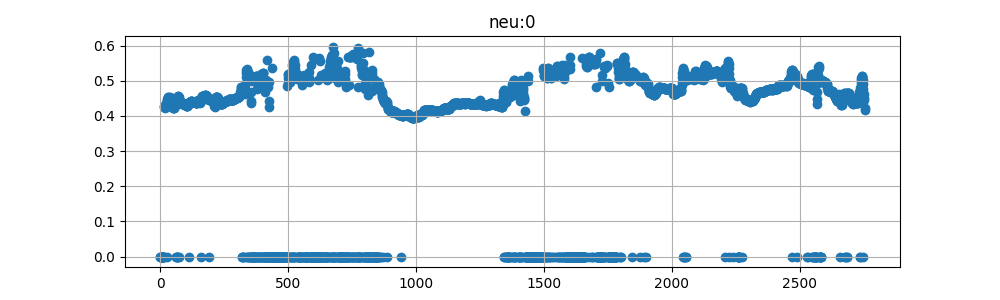

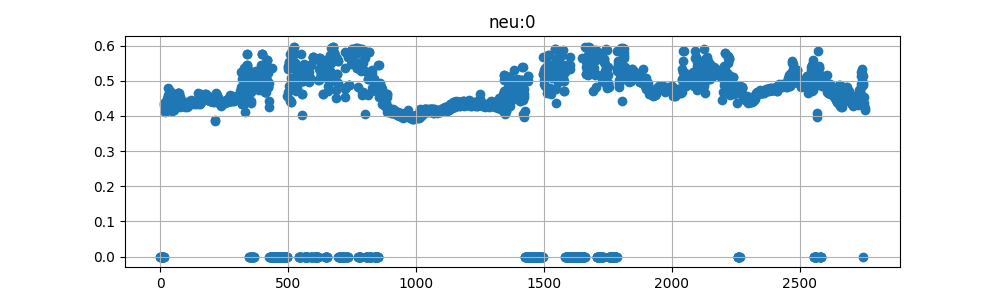

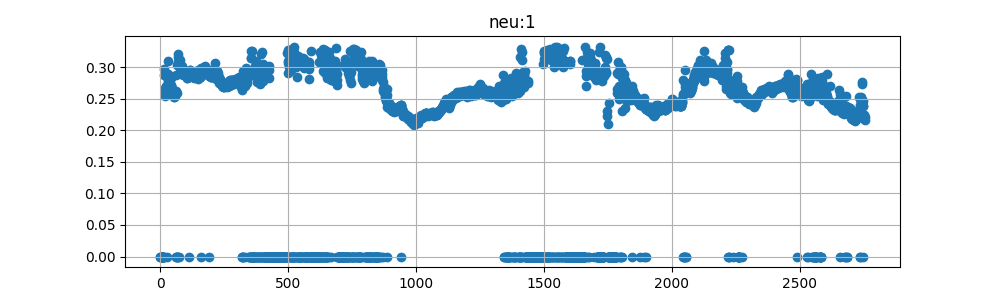

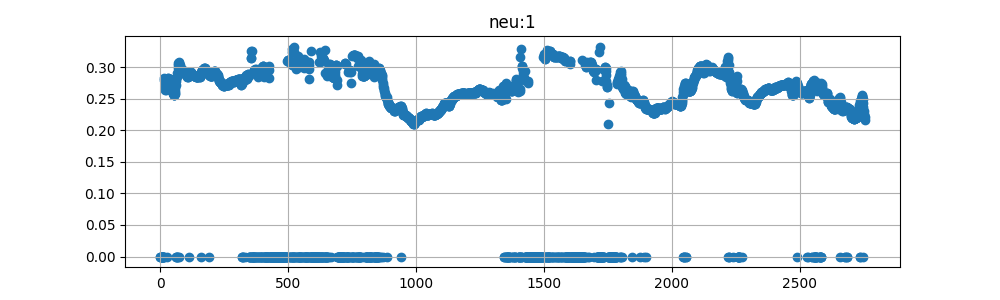

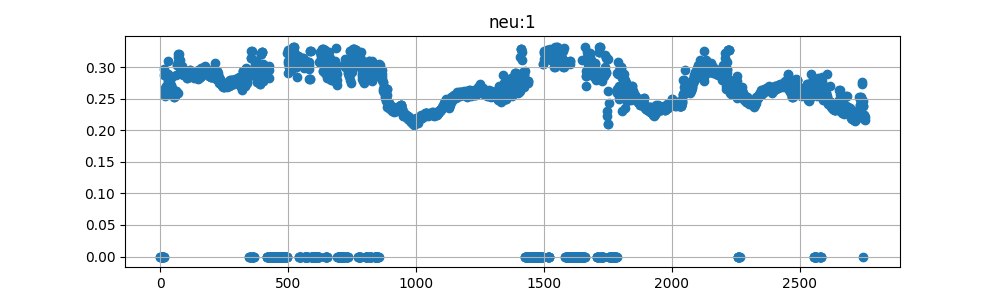

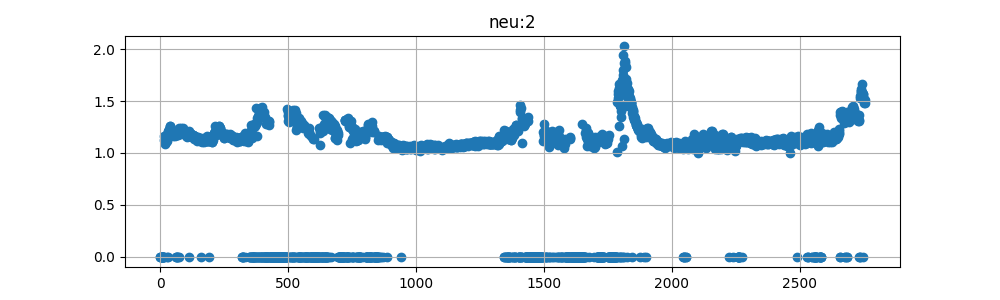

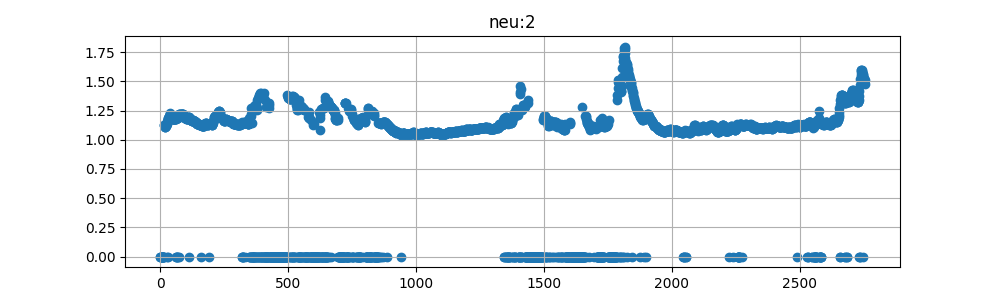

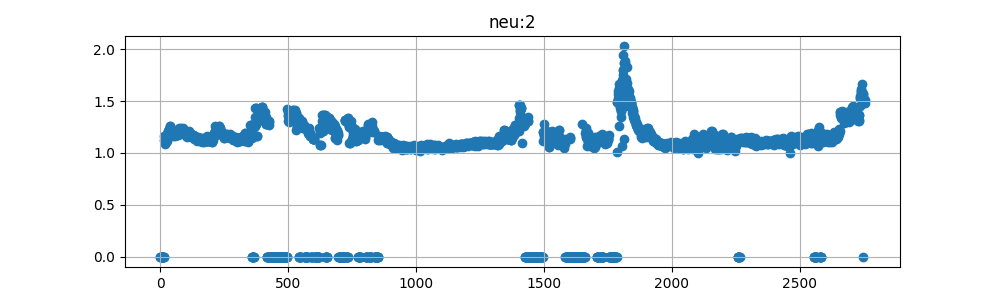

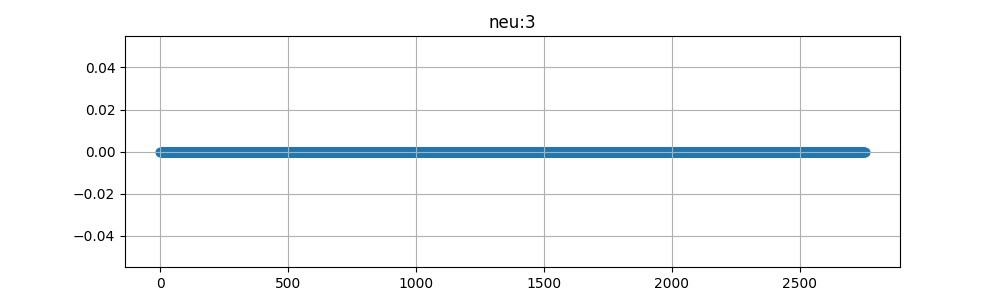

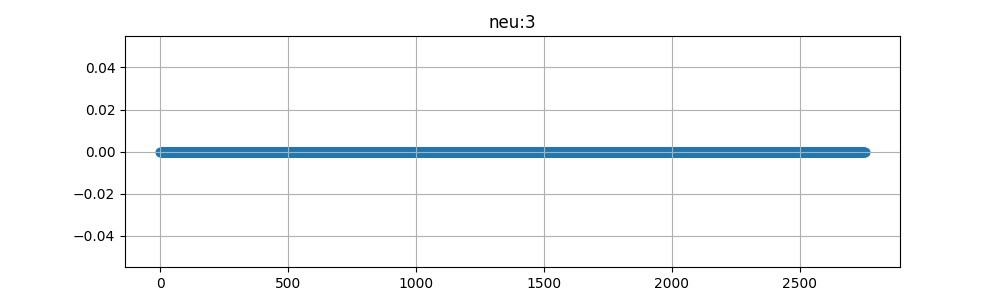

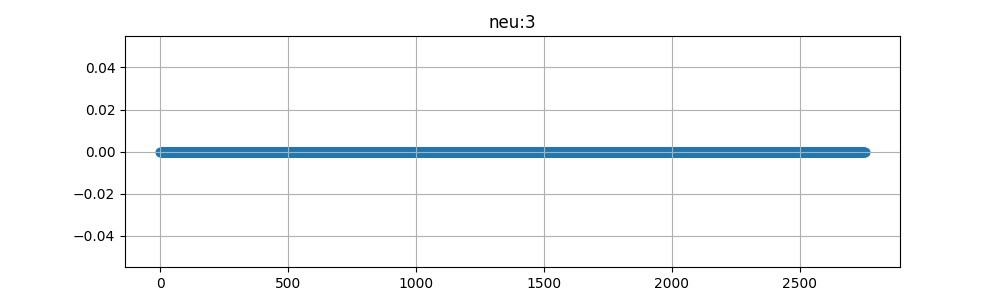

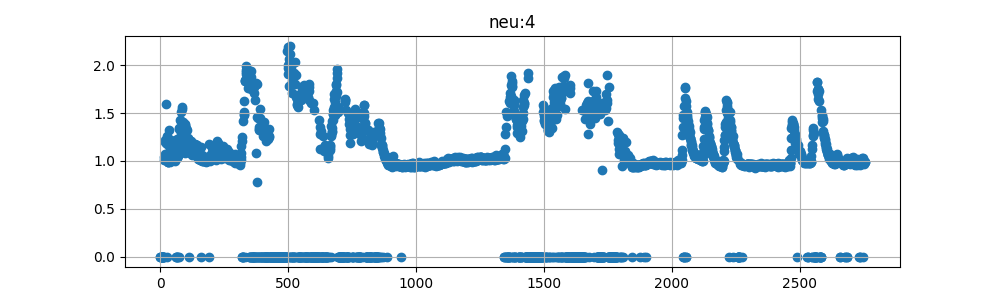

/mnt/DATA/Mahsa/movies/LongRecordings/codes/Cluster/Functions/UnifyWormsFun.py:356: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,3))


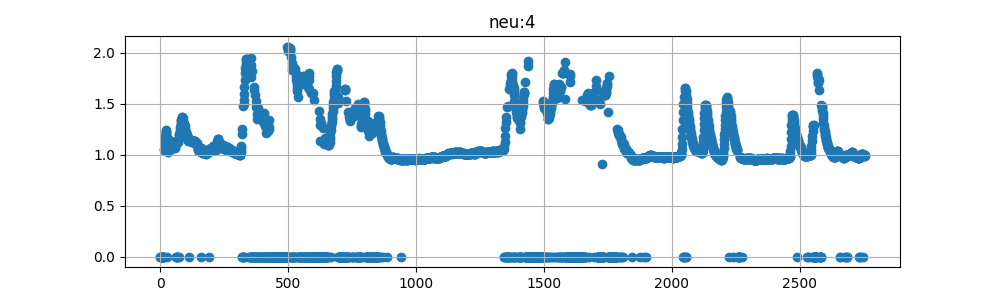

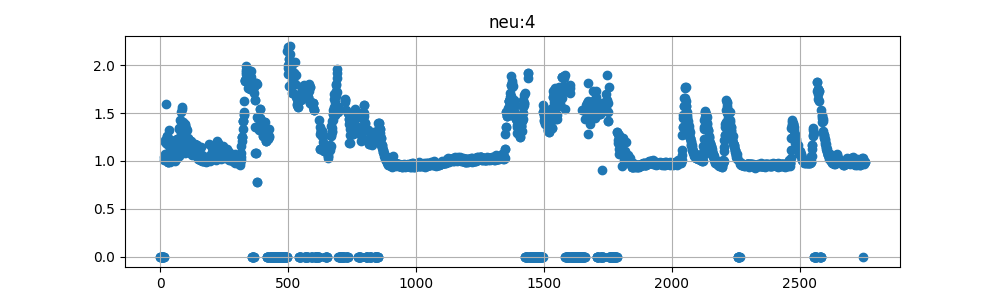

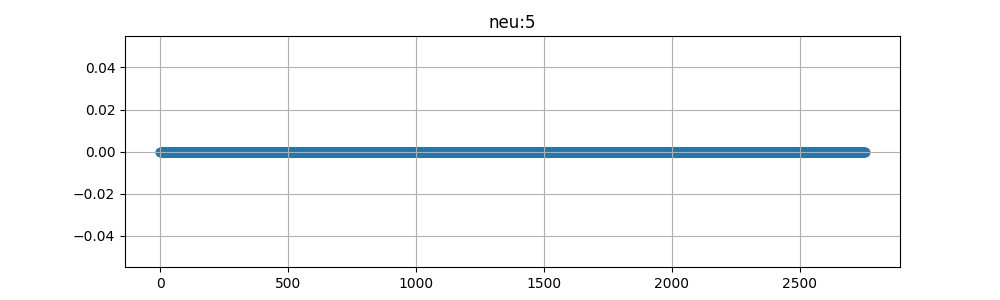

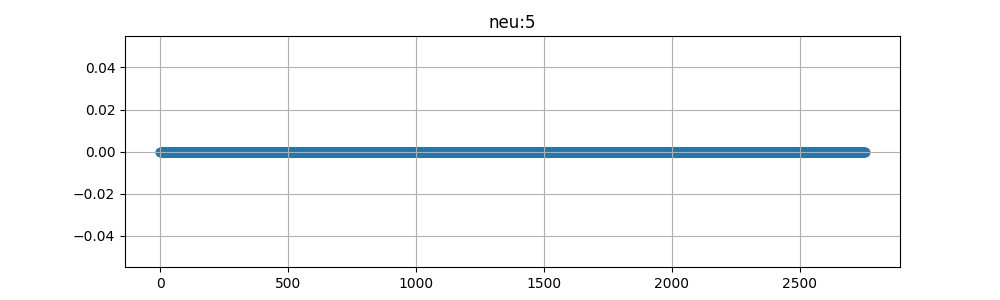

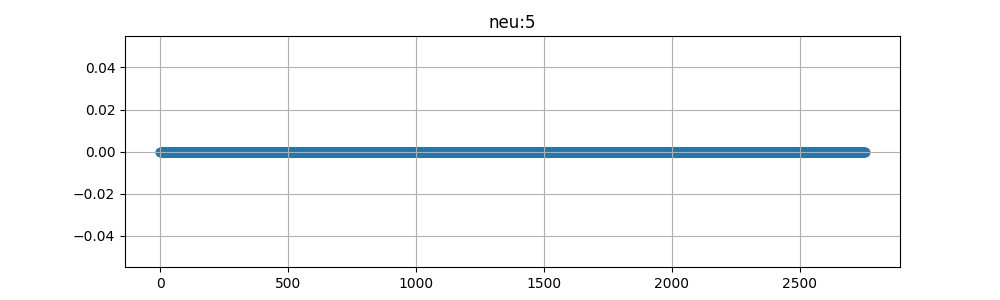

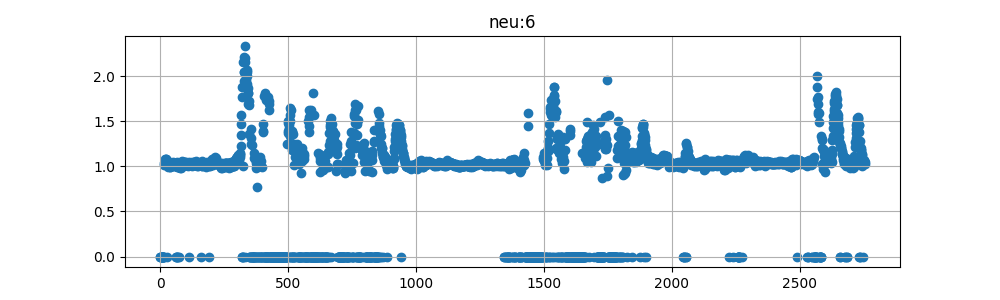

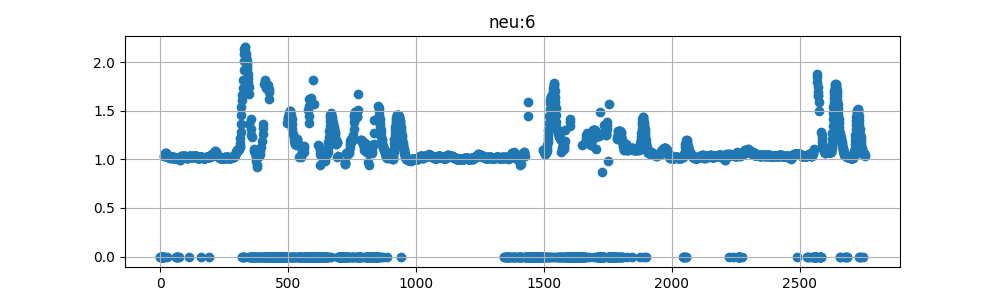

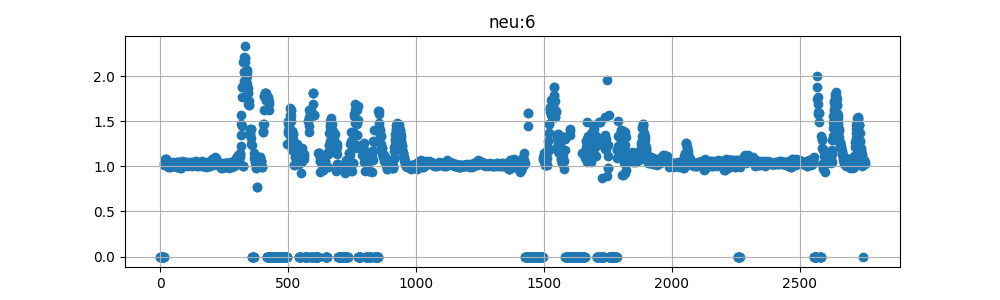

In [16]:
# for worm d and neurons RIA,RIM,RIB,sensory,  plot raw, smoothed, and gap filled separately
# xaxis is the frame number of confocal
d=0
for n in range(7):
    endt = L[d]
    xaxis = np.arange(endt)#MegaData0[d0,:endt,12]
    UNF.plot1d(xaxis,MegaData0[d,:endt,n],title='neu:'+str(n))
    UNF.plot1d(xaxis,MegaData[d,:endt,n],title='neu:'+str(n))
    UNF.plot1d(xaxis,MegaData_filled[d,:endt,n],title='neu:'+str(n))

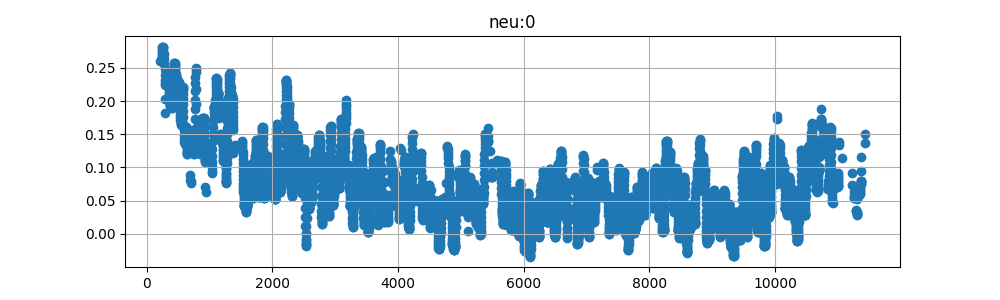

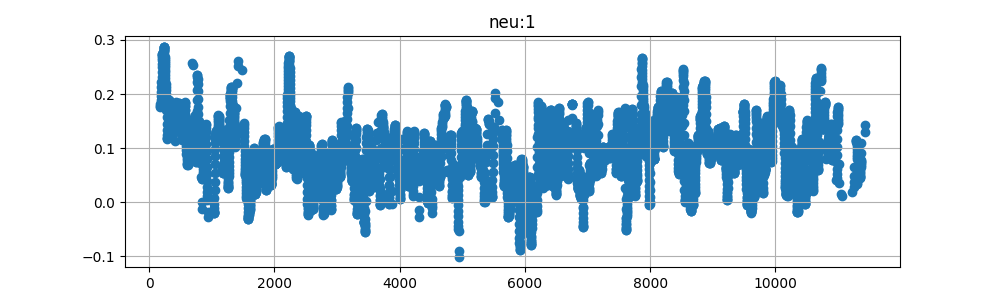

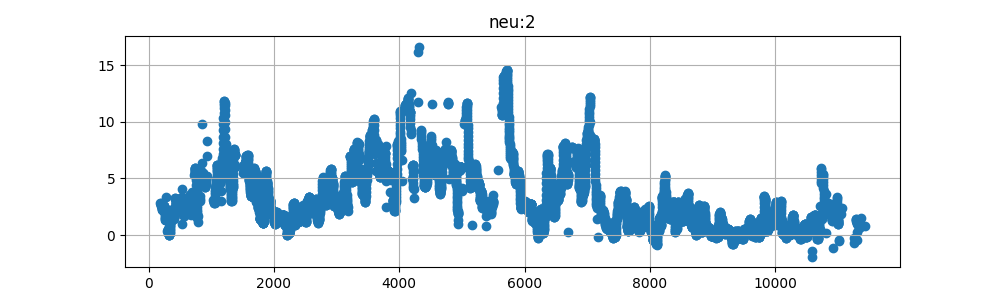

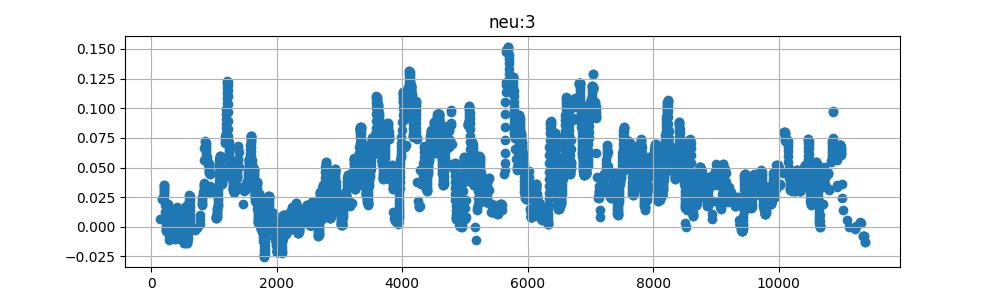

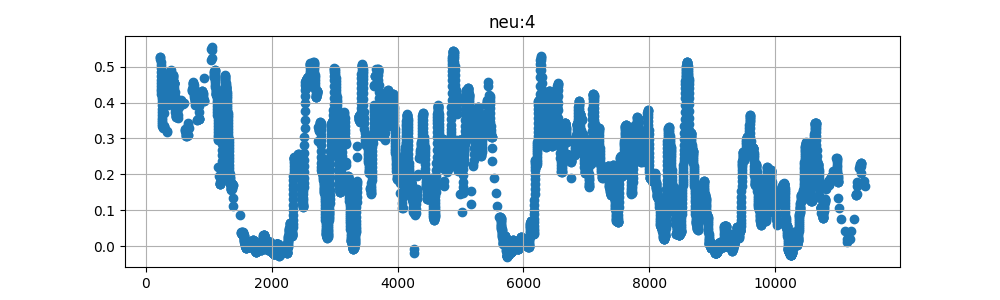

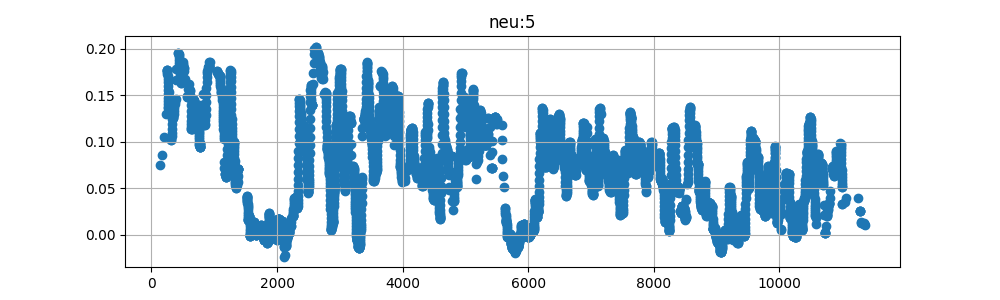

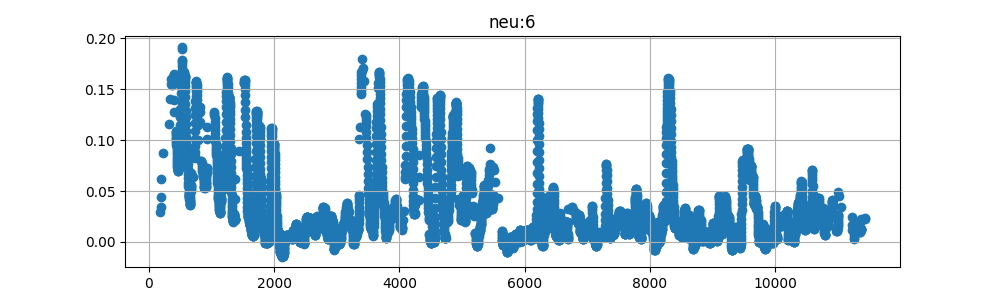

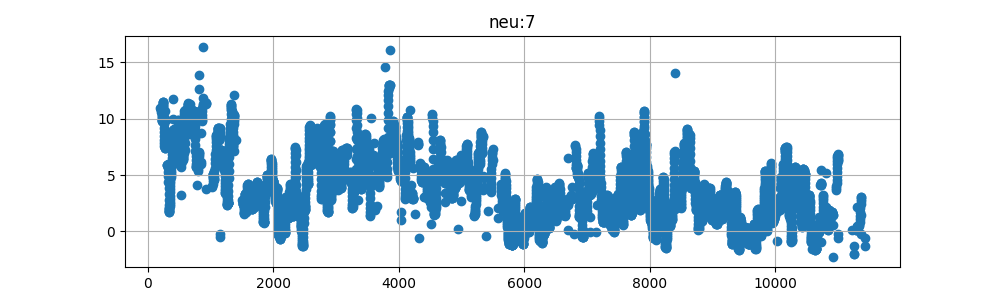

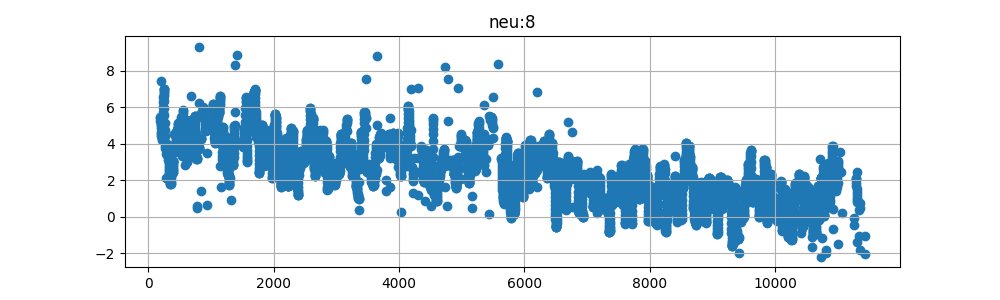

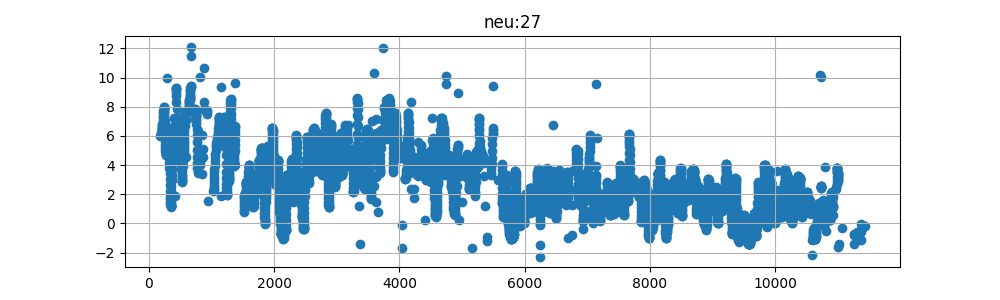

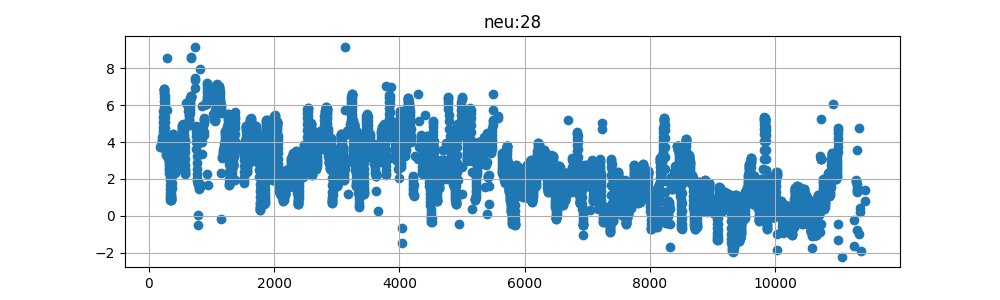

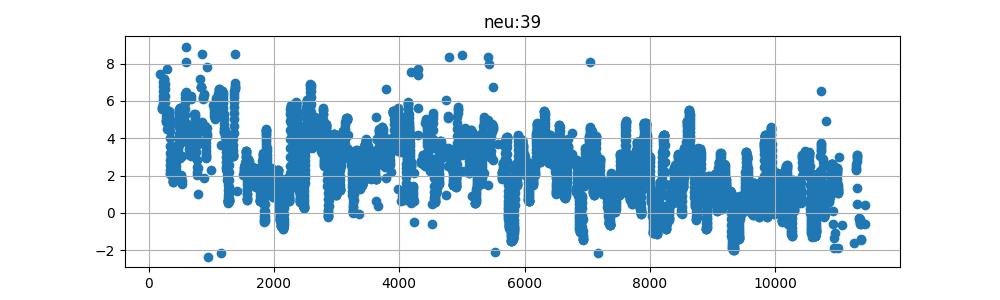

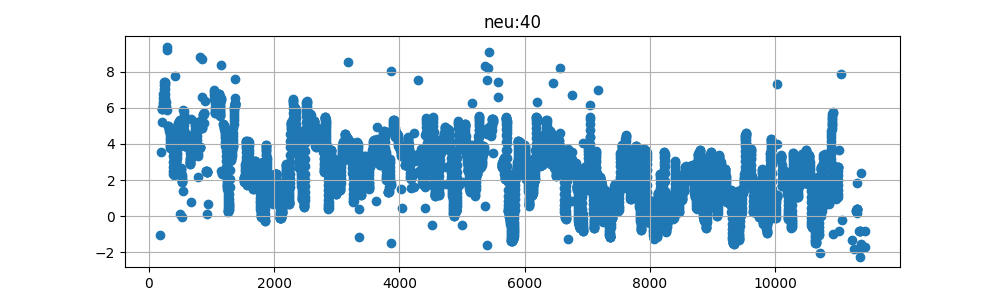

In [17]:
# for worm d and all neurons and neurites, plot smoothed data only at valid points (nonzero data points)
# the x axis is frame number in the behavioral camera
d=4
for n in [0,1,2,3,4,5,6,7,8,27,28,39,40]:
    nonz = np.nonzero(MegaData[d,:L[4],n])[0]
    UNF.plot1d(MegaData[d,nonz,11],MegaData[d,nonz,n],title='neu:'+str(n))